# **1. Importing Necessary Libraries:**

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import classification_report, roc_auc_score, roc_curve

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from scikeras.wrappers import KerasClassifier

# **2. Loading and understanding the dataset:**

In [ ]:
df1 = pd.read_csv("hf://datasets/marianeft/diabetes_prediction_dataset/diabetes_prediction_dataset.csv")

df = df1.copy()

print(df.head())

print(df.info())

print(df.describe())

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


   gender   age  hypertension  heart_disease smoking_history    bmi  \
0  Female  80.0             0              1           never  25.19   
1  Female  54.0             0              0         No Info  27.32   
2    Male  28.0             0              0           never  27.32   
3  Female  36.0             0              0         current  23.45   
4    Male  76.0             1              1         current  20.14   

   HbA1c_level  blood_glucose_level  diabetes  
0          6.6                  140         0  
1          6.6                   80         0  
2          5.7                  158         0  
3          5.0                  155         0  
4          4.8                  155         0  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 9 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   gender               100000 non-null  object 
 1   age               

# **3. Data preprocessing:**

# A. Checking for missing values:

In [ ]:
print(df.isnull().sum())

gender                 0
age                    0
hypertension           0
heart_disease          0
smoking_history        0
bmi                    0
HbA1c_level            0
blood_glucose_level    0
diabetes               0
dtype: int64


# B. Checking gender-wise distribution of diabetes:

Gender Count:
Female    58552
Male      41430
Other        18

Gender Percentage:
Female    58.552
Male      41.430
Other      0.018
Percentage of people in each gender with diabetes:
Female    7.618869
Male      9.748974
Other     0.000000


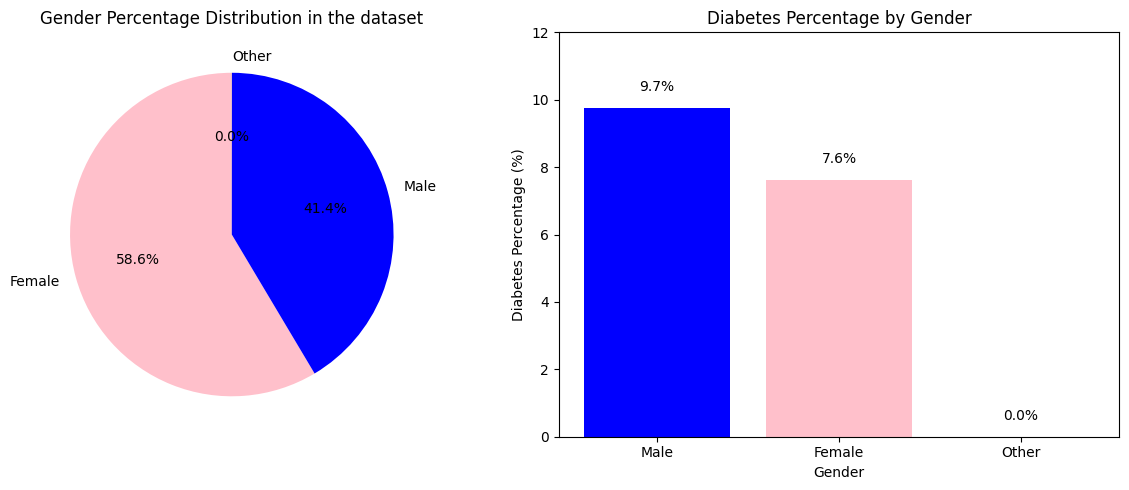

In [ ]:
gender_counts = df['gender'].value_counts()

gender_percentage = df['gender'].value_counts(normalize=True) * 100

diabetes_percentage = df.groupby('gender')['diabetes'].mean() * 100

print("Gender Count:")
print(gender_counts.to_string(header=False))
print("\nGender Percentage:")
print(gender_percentage.to_string(header=False))
print("Percentage of people in each gender with diabetes:")
print(diabetes_percentage.to_string(header=False))

color_map = {"male": "blue", "female": "pink"}
plt.figure(figsize=(12, 5))

pie_colors = [color_map.get(g.lower(), "gray") for g in gender_percentage.index]
plt.subplot(1, 2, 1)
plt.pie(gender_percentage, labels=gender_percentage.index, autopct='%1.1f%%', startangle=90, colors=pie_colors)
plt.title("Gender Percentage Distribution in the dataset")

diabetes_percentage_ordered = diabetes_percentage.sort_values(ascending=False)
bar_colors = [color_map.get(g.lower(), "gray") for g in diabetes_percentage_ordered.index]
plt.subplot(1, 2, 2)
plt.bar(diabetes_percentage_ordered.index, diabetes_percentage_ordered.values, color=bar_colors)
plt.title("Diabetes Percentage by Gender")
plt.xlabel("Gender")
plt.ylabel("Diabetes Percentage (%)")
plt.ylim(0, 12)
for i, value in enumerate(diabetes_percentage_ordered.values):
    plt.text(i, value + 0.5, f"{value:.1f}%", ha="center")

plt.tight_layout()
plt.show()

# C. Checking smoking history-wise distribution of diabetes:

Smoking History Count:
No Info        35816
never          35095
former          9352
current         9286
not current     6447
ever            4004

Smoking History Percentage:
No Info        35.816
never          35.095
former          9.352
current         9.286
not current     6.447
ever            4.004

Percentage of people in each smoking history with diabetes:
No Info         4.059638
current        10.208917
ever           11.788212
former         17.001711
never           9.534122
not current    10.702652


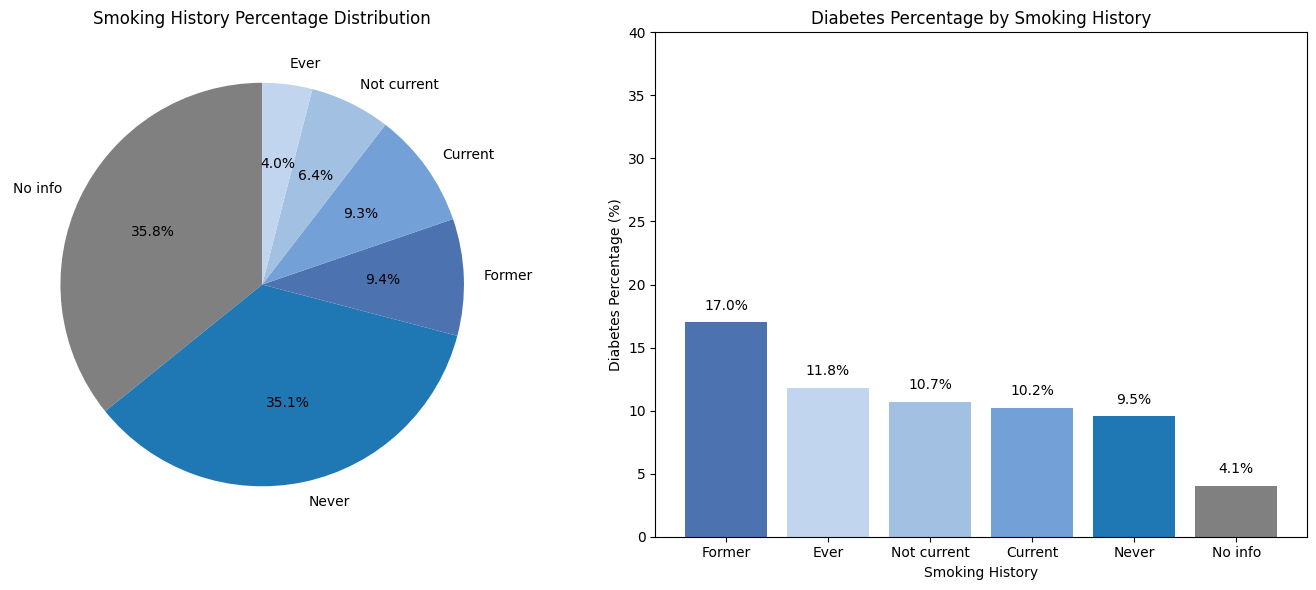

In [ ]:
smoking_history_counts = df['smoking_history'].value_counts()

smoking_history_percentage = df['smoking_history'].value_counts(normalize=True) * 100

diabetes_percentage_smoking = df.groupby('smoking_history')['diabetes'].mean() * 100

print("Smoking History Count:")
print(smoking_history_counts.to_string(header=False))
print("\nSmoking History Percentage:")
print(smoking_history_percentage.to_string(header=False))
print("\nPercentage of people in each smoking history with diabetes:")
print(diabetes_percentage_smoking.to_string(header=False))

color_map = {
    "never": "#1f77b4",
    "former": "#4c72b0",
    "current": "#74a0d8",
    "not current": "#a2c0e2",
    "ever": "#c2d5ef"
}
plt.figure(figsize=(14, 6))

pie_labels = [label.capitalize() for label in smoking_history_percentage.index]
pie_sizes = smoking_history_percentage.values
pie_colors = [color_map.get(label.lower(), "gray") for label in pie_labels]
plt.subplot(1, 2, 1)
plt.pie(pie_sizes, labels=pie_labels, autopct='%1.1f%%', startangle=90, colors=pie_colors)
plt.title("Smoking History Percentage Distribution")
plt.subplot(1, 2, 2)

diabetes_sorted = diabetes_percentage_smoking.sort_values(ascending=False)
bar_labels = [label.capitalize() for label in diabetes_sorted.index]
bar_values = diabetes_sorted.values
bar_colors = [color_map.get(label.lower(), "gray") for label in bar_labels]
bars = plt.bar(bar_labels, bar_values, color=bar_colors)
plt.title("Diabetes Percentage by Smoking History")
plt.xlabel("Smoking History")
plt.ylabel("Diabetes Percentage (%)")
plt.ylim(0, 40)
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height + 1, f"{height:.1f}%", ha="center")

plt.tight_layout()
plt.show()

# D. Encoding categorical variables:

In [ ]:
df['gender'] = df['gender'].map({'Male': 2, 'Female': 1, 'Other': 0})

encoder = OneHotEncoder(drop=None)

encoded_array = encoder.fit_transform(df[['smoking_history']]).toarray()

encoded_df = pd.DataFrame(encoded_array, columns=encoder.get_feature_names_out(['smoking_history']), index=df.index)

df = pd.concat([df.drop(columns=['smoking_history']), encoded_df], axis=1)

print(df.head())

   gender   age  hypertension  heart_disease    bmi  HbA1c_level  \
0       1  80.0             0              1  25.19          6.6   
1       1  54.0             0              0  27.32          6.6   
2       2  28.0             0              0  27.32          5.7   
3       1  36.0             0              0  23.45          5.0   
4       2  76.0             1              1  20.14          4.8   

   blood_glucose_level  diabetes  smoking_history_No Info  \
0                  140         0                      0.0   
1                   80         0                      1.0   
2                  158         0                      0.0   
3                  155         0                      0.0   
4                  155         0                      0.0   

   smoking_history_current  smoking_history_ever  smoking_history_former  \
0                      0.0                   0.0                     0.0   
1                      0.0                   0.0                     0.0

# E. Features and Target Split:

In [ ]:
X = df.drop(columns=['diabetes'])
Y = df['diabetes']

# F. Test and Train Split:

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.25, random_state=42, stratify=Y)

# **4. Model building:**

In [ ]:
results = {}

# A. Logistic Regression Model:

Logistic Regression Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.99      0.98     22875
           1       0.86      0.64      0.73      2125

    accuracy                           0.96     25000
   macro avg       0.92      0.81      0.86     25000
weighted avg       0.96      0.96      0.96     25000



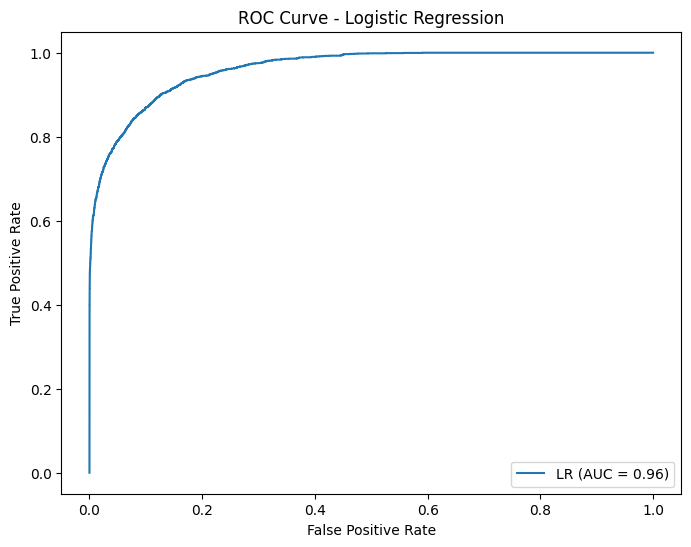

In [ ]:
pipe_lr = Pipeline([
    ('scaler', StandardScaler()),
    ('lr', LogisticRegression(solver='liblinear'))
])

pipe_lr.fit(X_train, Y_train)

y_pred_lr = pipe_lr.predict(X_test)

print("Logistic Regression Classification Report:")
print(classification_report(Y_test, y_pred_lr))

y_proba_lr = pipe_lr.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(Y_test, y_proba_lr)
roc_auc_lr = roc_auc_score(Y_test, y_proba_lr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'LR (AUC = {roc_auc_score(Y_test, y_proba_lr):.2f})')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Logistic Regression")
plt.legend(loc='lower right')
plt.show()

results['Logistic Regression'] = {
    'ROC AUC': roc_auc_lr,
    'Classification Report': classification_report(Y_test, y_pred_lr, output_dict=True)
}

# B. Support Vector Machine (SVM) Model:

SVM Classification Report:
              precision    recall  f1-score   support

           0       0.96      1.00      0.98     22875
           1       0.97      0.59      0.73      2125

    accuracy                           0.96     25000
   macro avg       0.97      0.79      0.86     25000
weighted avg       0.96      0.96      0.96     25000



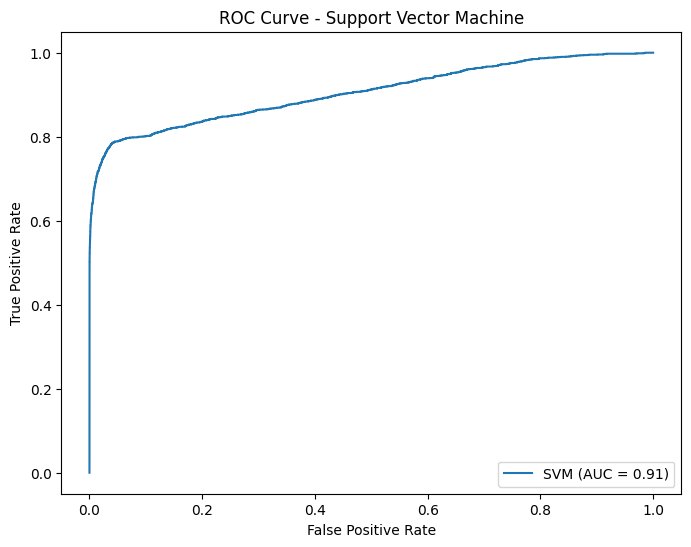

In [ ]:
pipe_svm = Pipeline([
    ('scaler', StandardScaler()),
    ('svm', SVC(kernel='rbf', probability=True, random_state=1))
])

pipe_svm.fit(X_train, Y_train)

y_pred_svm = pipe_svm.predict(X_test)

print("SVM Classification Report:")
print(classification_report(Y_test, y_pred_svm))

y_proba_svm = pipe_svm.predict_proba(X_test)[:, 1]
roc_auc_svm = roc_auc_score(Y_test, y_proba_svm)
fpr, tpr, thresholds = roc_curve(Y_test, y_proba_svm)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'SVM (AUC = {roc_auc_svm:.2f})')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Support Vector Machine')
plt.legend(loc='lower right')
plt.show()

results['SVM'] = {
    'ROC AUC': roc_auc_svm,
    'Classification Report': classification_report(Y_test, y_pred_svm, output_dict=True)
}

# C. Deep Learning Model:

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Classification Report:
              precision    recall  f1-score   support

           0       0.97      1.00      0.99     22875
           1       0.98      0.69      0.81      2125

    accuracy                           0.97     25000
   macro avg       0.98      0.84      0.90     25000
weighted avg       0.97      0.97      0.97     25000



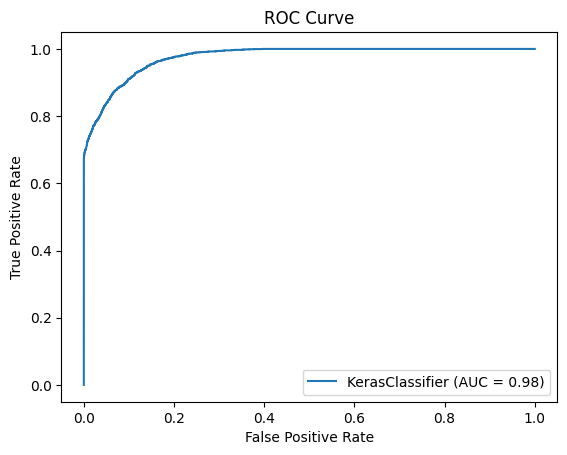

In [ ]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

def create_model():
    model = Sequential([
        Dense(32, activation='relu', input_shape=(X_train.shape[1],)),
        Dense(16, activation='relu'),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='nadam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

keras_clf = KerasClassifier(model=create_model, epochs=50, batch_size=16, verbose=0)

keras_clf.fit(X_train_scaled, Y_train, validation_data=(X_test_scaled, Y_test))

y_pred = (keras_clf.predict(X_test_scaled) > 0.5).astype(int)

print("Classification Report:")
print(classification_report(Y_test, y_pred))

y_proba = keras_clf.predict_proba(X_test_scaled)[:, 1]
roc_auc = roc_auc_score(Y_test, y_proba)
fpr, tpr, _ = roc_curve(Y_test, y_proba)

plt.plot(fpr, tpr, label=f'KerasClassifier (AUC = {roc_auc:.2f})')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

results['Deep Learning'] = {
    'ROC AUC': roc_auc,
    'Classification Report': classification_report(Y_test, y_pred, output_dict=True)
}

# **5. Summary:**

In [ ]:
for model_name, metrics in results.items():
    print(f"=== {model_name} ===")
    print("ROC AUC Score:", metrics['ROC AUC'])
    print("Classification Report:")
    report_df = pd.DataFrame(metrics['Classification Report']).transpose()
    print(report_df)
    print("\n")

=== Logistic Regression ===
ROC AUC Score: 0.9620563420122148
Classification Report:
              precision    recall  f1-score      support
0              0.967220  0.990645  0.978792  22875.00000
1              0.863781  0.638588  0.734307   2125.00000
accuracy       0.960720  0.960720  0.960720      0.96072
macro avg      0.915501  0.814617  0.856550  25000.00000
weighted avg   0.958428  0.960720  0.958011  25000.00000


=== SVM ===
ROC AUC Score: 0.9052089848923176
Classification Report:
              precision    recall  f1-score      support
0              0.963133  0.998164  0.980336  22875.00000
1              0.967517  0.588706  0.732007   2125.00000
accuracy       0.963360  0.963360  0.963360      0.96336
macro avg      0.965325  0.793435  0.856171  25000.00000
weighted avg   0.963506  0.963360  0.959228  25000.00000


=== Deep Learning ===
ROC AUC Score: 0.9759981176470587
Classification Report:
              precision    recall  f1-score      support
0              0.97179

# **6. Evaluation using a sample:**

In [ ]:
samples = [
    ('Male', 67, 0, 1, 'not current', 27.32, 6.5, 200),
    ('Female', 4, 0, 0, 'No Info', 13.99, 4, 140)
]

gender_mapping = {'Male': 2, 'Female': 1, 'Other': 0}
smoking_history_mapping = {
    "No Info": [1, 0, 0, 0, 0, 0],
    "current": [0, 1, 0, 0, 0, 0],
    "never": [0, 0, 1, 0, 0, 0],
    "former": [0, 0, 0, 1, 0, 0],
    "not current": [0, 0, 0, 0, 1, 0],
    "ever": [0, 0, 0, 0, 0, 1]
}

processed_samples = []
for sample in samples:
    gender = gender_mapping[sample[0]]
    age = sample[1]
    hypertension = sample[2]
    heart_disease = sample[3]
    smoking_history = smoking_history_mapping[sample[4]]
    bmi = sample[5]
    blood_glucose = sample[7]
    hba1c = sample[6]
    processed_samples.append([gender, age, hypertension, heart_disease] + smoking_history + [bmi, blood_glucose, hba1c])

processed_samples = np.array(processed_samples)
scaler = StandardScaler()
scaler.fit(X_train)
processed_samples_scaled = scaler.transform(processed_samples)

models = {
    "Logistic Regression": {"model": pipe_lr, "f1": 0.73},
    "SVM": {"model": pipe_svm, "f1": 0.73},
    "Deep Learning": {"model": keras_clf, "f1": 0.81}
}

predictions = {}
for model_name, details in models.items():
    model = details["model"]
    predictions[model_name] = model.predict(processed_samples_scaled)

final_decisions = []
for i in range(len(samples)):
    weighted_sum = sum(predictions[model_name][i] * models[model_name]["f1"] for model_name in models)
    total_auc = sum(models[model_name]["f1"] for model_name in models)
    final_decision = "Diabetes" if weighted_sum > (total_auc / 2) else "No Diabetes"
    final_decisions.append(final_decision)

for i, sample in enumerate(samples):
    print(f"\nSample {i+1}: {sample}")
    for model_name in models:
        outcome = "Diabetes" if predictions[model_name][i] == 1 else "No Diabetes"
        print(f"  {model_name}: {outcome} (F1 score: {models[model_name]['f1']})")
    print(f"  Final Decision (Weighted by F1 score): {final_decisions[i]}")


Sample 1: ('Male', 67, 0, 1, 'not current', 27.32, 6.5, 200)
  Logistic Regression: Diabetes (F1 score: 0.73)
  SVM: Diabetes (F1 score: 0.73)
  Deep Learning: No Diabetes (F1 score: 0.81)
  Final Decision (Weighted by F1 score): Diabetes

Sample 2: ('Female', 4, 0, 0, 'No Info', 13.99, 4, 140)
  Logistic Regression: Diabetes (F1 score: 0.73)
  SVM: Diabetes (F1 score: 0.73)
  Deep Learning: No Diabetes (F1 score: 0.81)
  Final Decision (Weighted by F1 score): Diabetes


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
